In [1]:
# Testing Regression Models

In [2]:
import os
import sys
import pandas as pd
import seaborn as sns
import pandas as pd
import ta

#from ../src.visualization.visualize import DisplayTicker
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from src.visualization.visualize import DisplayTicker
from src.features.build_features import BuildFeatures


In [3]:
MSFT = pd.read_csv('./.data/MSFT.csv')

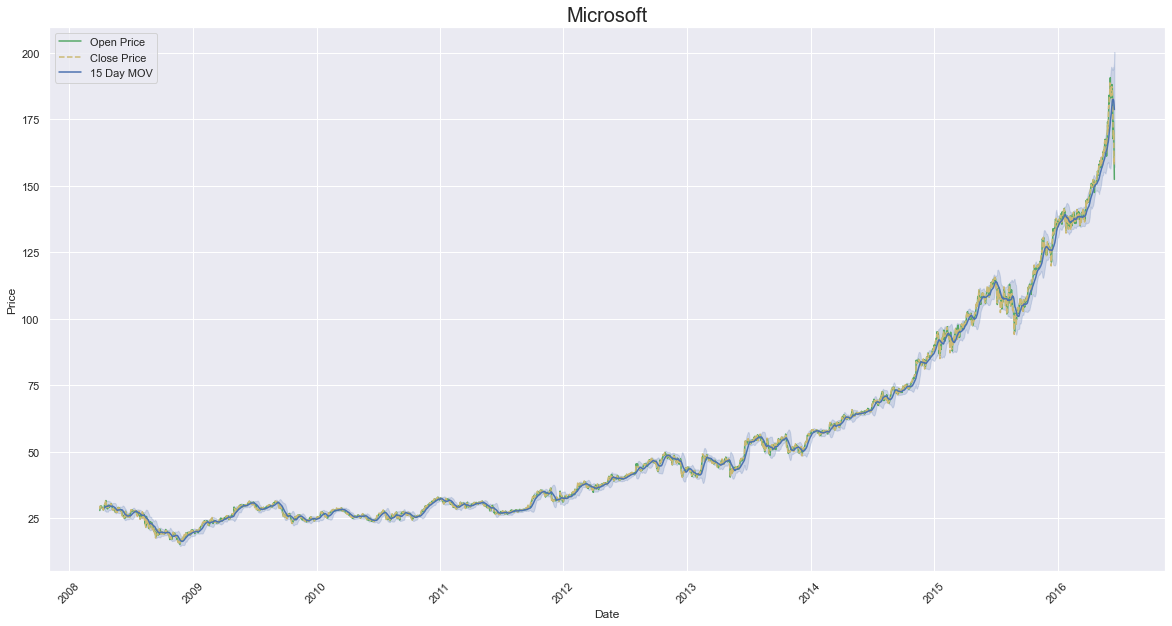

In [4]:
MSFT
MSFT_A = DisplayTicker(MSFT, "Microsoft")
MSFT_A.graph_stock()

In [11]:
indicator_bb = ta.volatility.BollingerBands(close=MSFT["Close"], n=20, ndev=2)
MSFT['bb_bbm'] = indicator_bb.bollinger_mavg()
MSFT['bb_bbh'] = indicator_bb.bollinger_hband()
MSFT['bb_bbl'] = indicator_bb.bollinger_lband()
# Add Bollinger Band high indicator
MSFT['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
MSFT['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

In [8]:
MSFT


,Date,Open,High,Low,Close,Adj Close,Volume,bb_bbm,bb_bbh,bb_bbl
0,2008-03-31,27.879999,28.590000,27.840000,28.379999,21.455233,46780600,28.379999,28.379999,28.379999
1,2008-04-01,28.830000,29.540001,28.629999,29.500000,22.301943,65796200,28.939999,30.060001,27.819998
2,2008-04-02,29.570000,29.580000,29.000000,29.160000,22.044899,49499400,29.013333,29.951038,28.075628
3,2008-04-03,29.000000,29.320000,28.799999,29.000000,21.923944,38961400,29.010000,29.822158,28.197841
4,2008-04-04,29.129999,29.260000,28.740000,29.160000,22.044899,43860800,29.040000,29.776261,28.303738
...,...,...,...,...,...,...,...,...,...,...
2996,2020-02-24,167.770004,174.550003,163.229996,170.889999,170.889999,68311100,178.801500,194.402686,163.200314
2997,2020-02-25,174.199997,174.839996,167.649994,168.070007,168.070007,68073300,179.091000,193.634134,164.547866
2998,2020-02-26,169.710007,173.259995,168.210007,170.169998,170.169998,56206100,179.326500,193.111890,165.541110
2999,2020-02-27,163.320007,167.029999,157.979996,158.179993,158.179993,93174900,178.833500,194.740186,162.926813
